# Visualization of the results of the chunking experiments

In [21]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

FIGURES_PATH = Path("figures/")

sns.set_theme(
    style="whitegrid",
    context="paper",
    font="DejaVu Serif",
    font_scale=1.3,
    palette="pastel",
)

DPI = 150
FIGSIZE_S = (8, 5)
FIGSIZE_L = (15, 5)

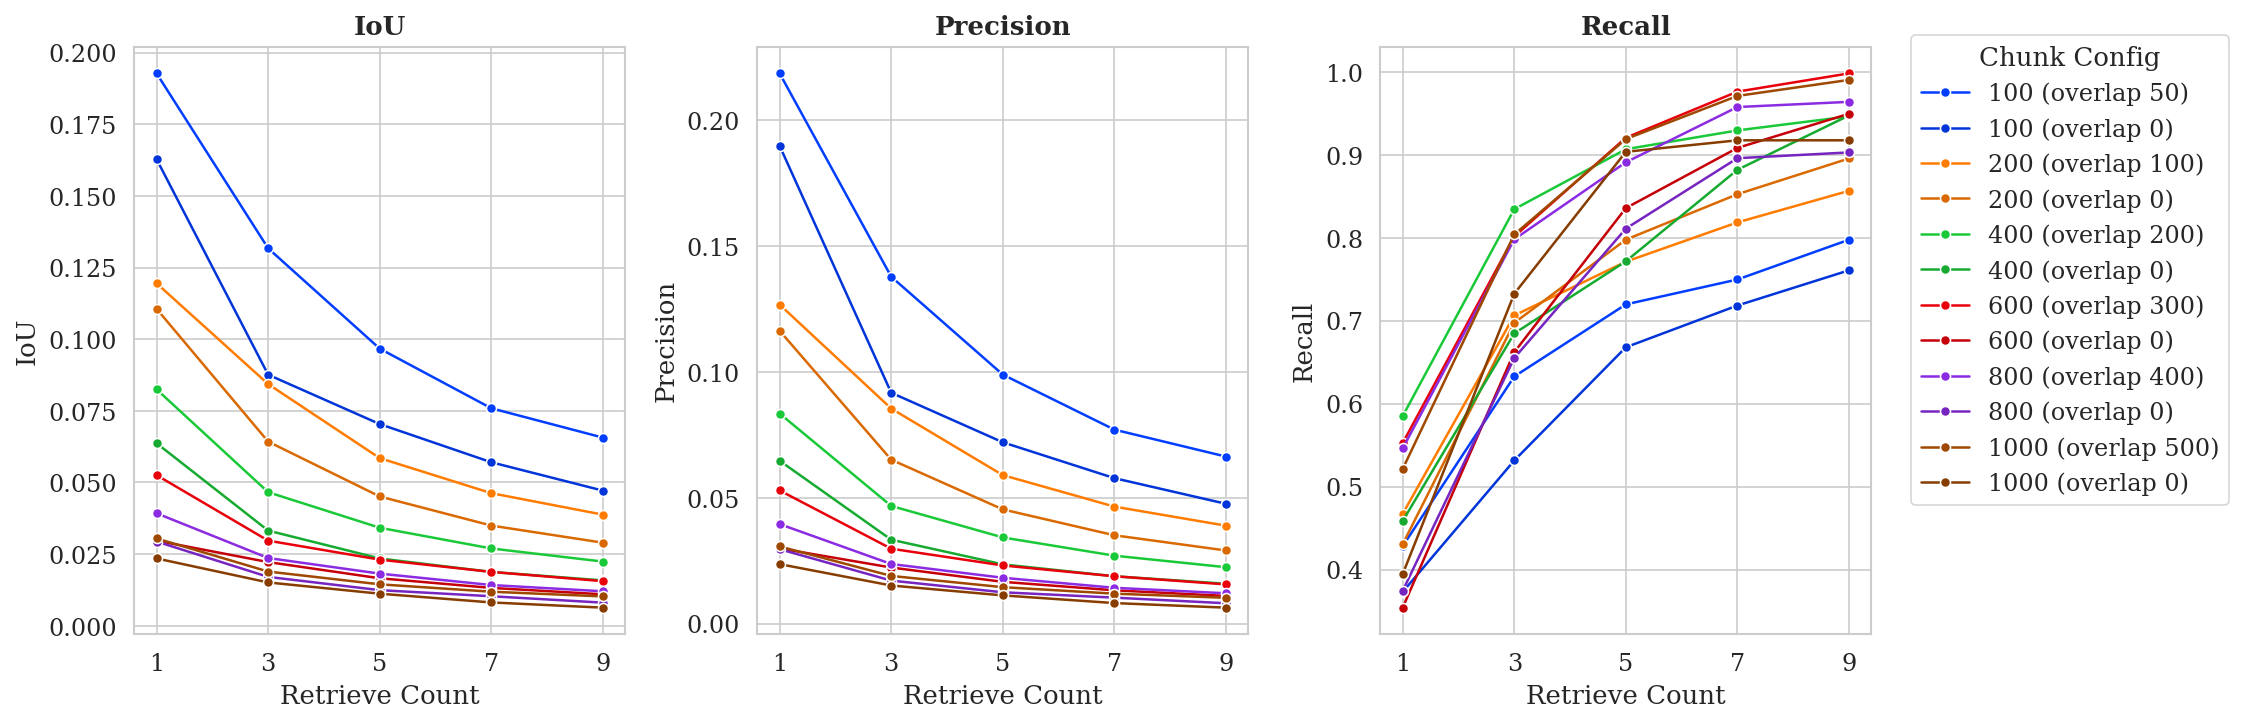

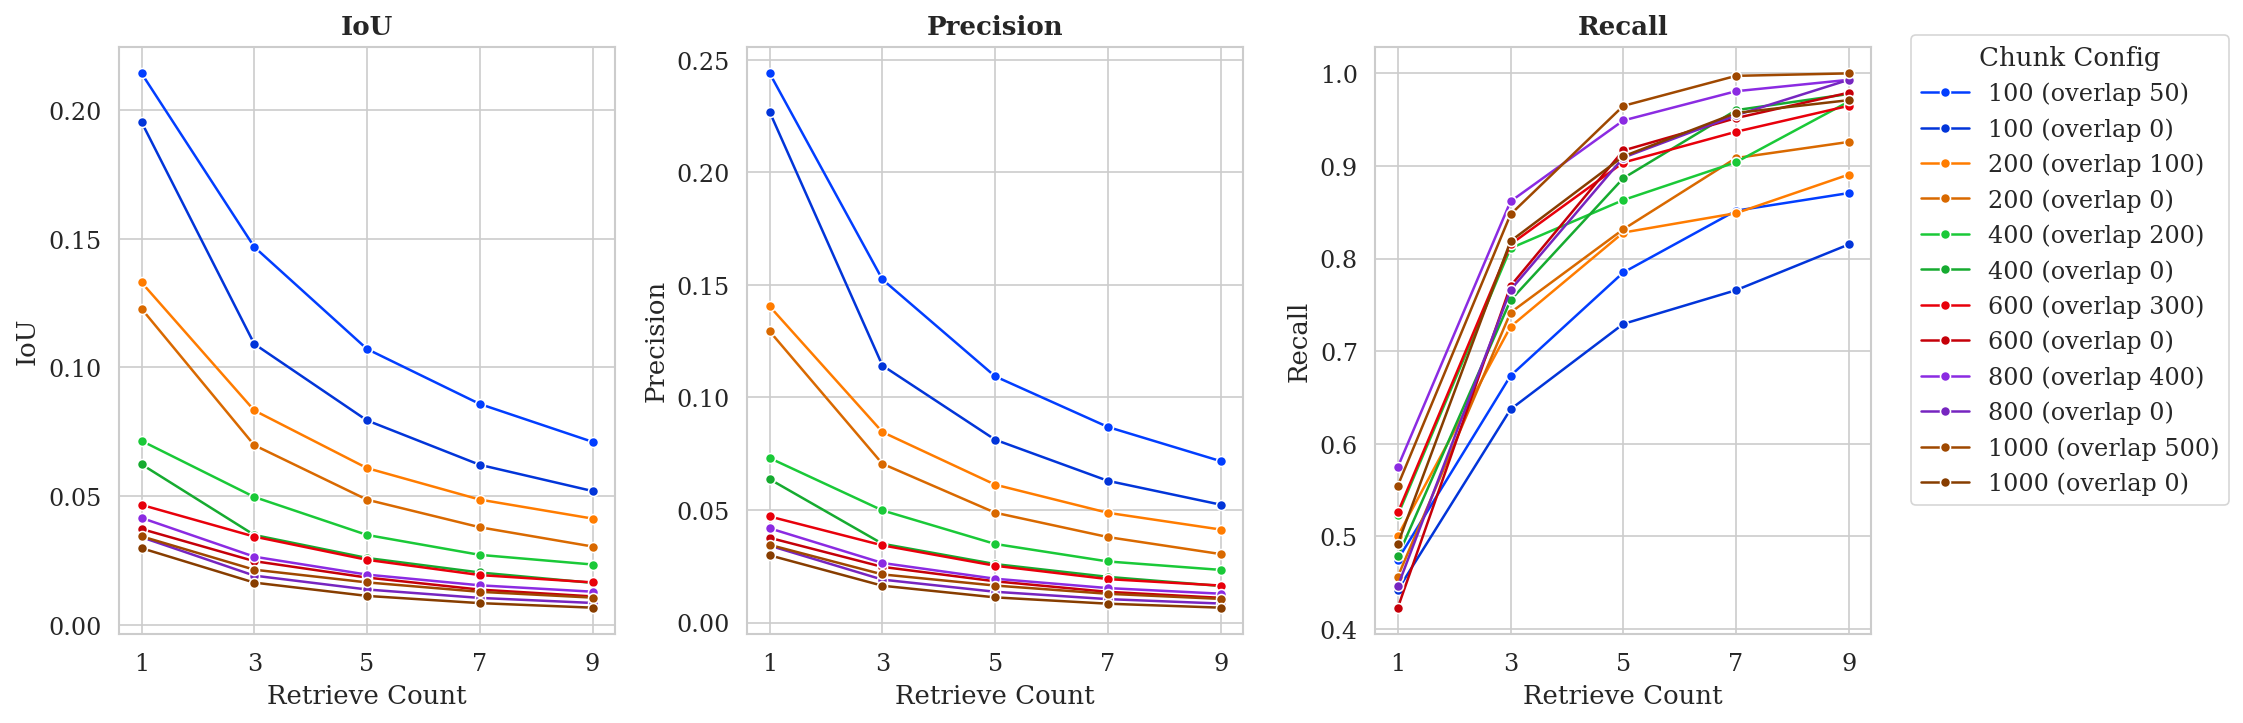

In [40]:
def plot_metrics_comparison(df, model_name, save_path):
    df_filtered = df[
        (df["embedding_function"] == model_name) & 
        (df["corpus"] == "wikitexts")
    ].copy()

    df_filtered.loc[:, "config"] = df_filtered["chunk_size"].astype(str) + " (overlap " + df_filtered["chunk_overlap"].astype(str) + ")"

    unique_sizes = sorted(df_filtered["chunk_size"].unique())
    base_colors = sns.color_palette("bright", n_colors=len(unique_sizes))
    palette = {}
    for i, size in enumerate(unique_sizes):
        size_configs = df_filtered[df_filtered["chunk_size"] == size]["config"].unique()
        shades = [base_colors[i]] * len(size_configs)
        if len(size_configs) > 1:
            shades[1] = tuple(x * 0.85 for x in base_colors[i])
        palette.update(dict(zip(size_configs, shades)))

    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_L, dpi=DPI, sharex=True)
    metrics = [("iou", "IoU"), ("precision", "Precision"), ("recall", "Recall")]
    retrieve_counts = sorted(df_filtered["retrieve_count"].unique())

    for ax, (metric, title) in zip(axes, metrics):
        sns.lineplot(
            data=df_filtered,
            x="retrieve_count", 
            y=metric,
            hue="config",
            marker="o",
            ax=ax,
            palette=palette,
        )
        ax.set_title(title, fontweight='semibold')
        ax.set_xlabel("Retrieve Count", fontweight='medium')
        ax.set_ylabel(title, fontweight='medium')
        ax.set_xticks(retrieve_counts)
        ax.legend_.remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Chunk Config", bbox_to_anchor=(0.85, 0.95), loc="upper left")
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(str(save_path), bbox_inches="tight", dpi=DPI)
    plt.show()

df = pd.read_csv("data/results.csv")

plot_metrics_comparison(df, "all-MiniLM-L6-v2", FIGURES_PATH / "metrics_comparison_all-MiniLM-L6-v2.png")
plot_metrics_comparison(df, "multi-qa-mpnet-base-dot-v1", FIGURES_PATH / "metrics_comparison_multi-qa-mpnet-base-dot-v1.png")

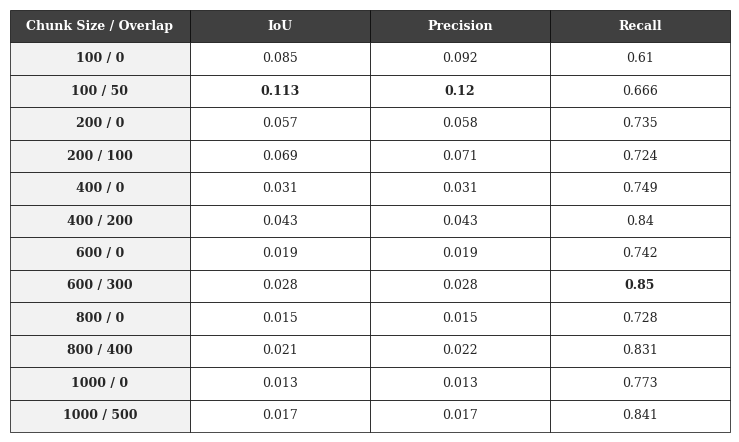

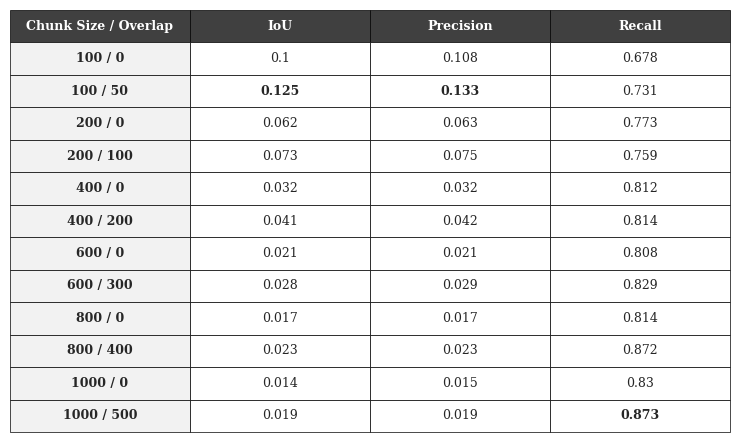

In [53]:
def plot_metrics_table(df, model_name, save_path):
    df_filtered = df[df['embedding_function'] == model_name]
    
    numeric_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns
    group_data = df_filtered.groupby(
        ['chunk_size', 'chunk_overlap'], as_index=False
    )[numeric_cols].mean()

    metric_cols = [m for m in ["iou", "precision", "recall", "f1"] if m in group_data.columns]
    group_data[metric_cols] = group_data[metric_cols].round(3)
    group_data["Config"] = group_data.apply(
        lambda row: f"{int(row['chunk_size'])} / {int(row['chunk_overlap'])}", axis=1
    )

    table_data = group_data.sort_values("chunk_size")[["Config"] + metric_cols]
    
    metric_display_names = {
        "iou": "IoU",
        "precision": "Precision", 
        "recall": "Recall",
    }
    
    column_names = ["Chunk Size / Overlap"] + [metric_display_names[m] for m in metric_cols]
    table_data.columns = column_names

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('off')
    
    table = ax.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5) 

    # Style table cells
    for (row, col), cell in table._cells.items():
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#404040')
        else:
            cell.set_facecolor('#f2f2f2' if col == 0 else 'white')
            if col == 0:
                cell.set_text_props(weight='bold')
            elif table_data.iloc[row-1, col] == table_data[table_data.columns[col]].max():
                cell.get_text().set_fontweight('bold')

    plt.subplots_adjust(left=1, right=2, top=2, bottom=1)
    plt.savefig(str(save_path), bbox_inches='tight', pad_inches=0, dpi=DPI)
    plt.show()

plot_metrics_table(df, "all-MiniLM-L6-v2", FIGURES_PATH / "metrics_table_all-MiniLM-L6-v2.png")
plot_metrics_table(df, "multi-qa-mpnet-base-dot-v1", FIGURES_PATH / "metrics_table_multi-qa-mpnet-base-dot-v1.png")
